In [1]:
from __future__ import print_function

import numpy as np
import h5py, os, sys, glob
sys.path.append('../lib')
from glob import glob

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from prettytable import PrettyTable

import ROOT as rt

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_ratio_plot

from cebefo_style import cebefo_style
cebefo_style()

dnd = []

Welcome to JupyROOT 6.16/00


In [2]:
Mjj_selection = 700.

vae_loss = 'mae'

SM_eff = 1e-2

def computeDiscriminatingVar(x):
    out = x[:,-2]/x[:,1]+x[:,-1]/x[:,6]
    out *= 1e5
    return out

# def computeDiscriminatingVar(x):
#     out = x[:,-2]+x[:,-1]
#     return out*1e4

# Get the discrimination on the side-band

['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1Loss', 'j2Loss']
(209109, 13)


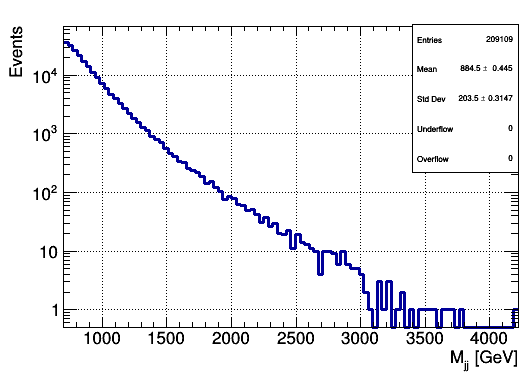

In [3]:
f = h5py.File('../data/vae_'+vae_loss+'/qcd_dEta_sideband_results.h5', 'r')
print(list(f.get("labels")))

data_side = np.array(f.get("results"))

# apply the dijet mass cut
data_side = data_side[data_side[:,0] > Mjj_selection]
print(data_side.shape)

c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_side = create_TH1D(data_side[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                opt='overflow', 
                binning=[100, Mjj_selection, np.max(data_side[:,0])])

h_Mjj_side.Draw()
c.SetLogy()
c.Draw()

### Train the model to predict the cut

In [4]:
x = np.reshape(data_side[:,0], (-1,1))
y = computeDiscriminatingVar(data_side)
print(np.mean(y))

103.62135082607014


In [5]:
gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=5,
                                min_samples_split=5,
                                validation_fraction=0.5,
                                n_iter_no_change=3,
                                tol=1e-5,
                                verbose=1)

gbr_cut.fit(x, y);

      Iter       Train Loss   Remaining Time 
         1           0.3955           10.33s
         2           0.3948            9.04s
         3           0.3943            8.47s
         4           0.3938            8.14s
         5           0.3934            8.06s
         6           0.3930            8.18s
         7           0.3927            8.18s
         8           0.3925            8.13s
         9           0.3923            7.96s
        10           0.3921            7.82s


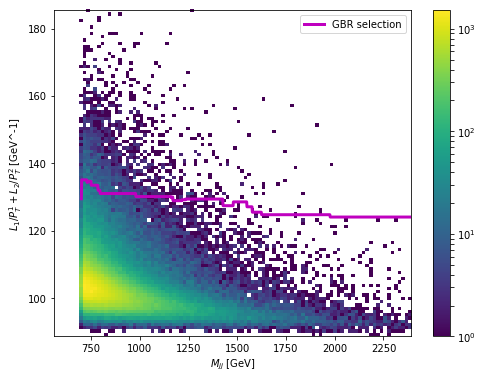

In [6]:
plt.figure(figsize=(8, 6))
x_min = Mjj_selection*0.8
x_max = np.quantile(x, 0.999)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.quantile(y, 1-1e-4))), 
           norm=LogNorm(), bins=100,
           label='Side band data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-x_min))
plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1/P^1_T + L_2/P^2_T$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

In [7]:
def getSelection(x_Mjj, x_loss):
    cut = gbr_cut.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut

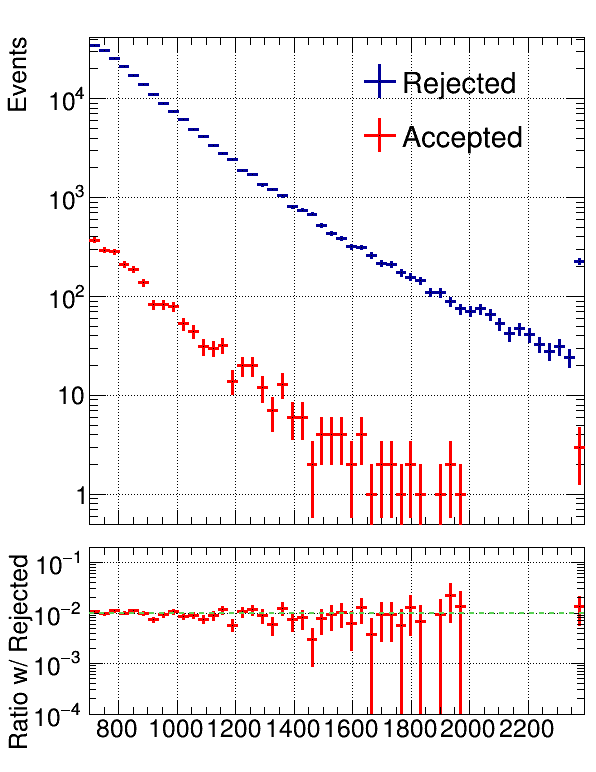

In [8]:
x = x.flatten()
binning=[50, Mjj_selection, np.quantile(x, 0.999)]

sel = getSelection(x, y)
h_a = create_TH1D(x[sel], 
                  name='h_acc', title='Accepted',
                  binning=binning,
                  opt='overflow'
                 )
h_a.SetLineColor(2)
h_a.SetStats(0)
h_a.Sumw2()
h_r = create_TH1D(x[np.logical_not(sel)], 
                  name='h_rej', title='Rejected',
                  axis_title=['M_{jj} [GeV]', 'Events'],
                  binning=binning,
                  opt='overflow'
                 )
h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
h_r.SetStats(0)
h_r.Sumw2()

c = make_ratio_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E')
c.pad1.SetLogy()
c.pad2.SetLogy()

c.pad2.cd()
ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
ln.SetLineWidth(2)
ln.SetLineStyle(7)
ln.SetLineColor(8)
ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

c.Draw()

# Analyze signal region

### Get the data

In [9]:
sample_loc = {'qcd':'qcd_dEta_signalregion_results.h5',
              'AtoZZZ':'AtoHZ_to_ZZZ_13TeV_PU40_results.h5',
              'GtoWW':'RSGraviton_WW_NARROW_13TeV_PU40_results.h5',
              'GtoBtt':'RSGraviton_tt_BROAD_13TeV_PU40_results.h5',
              'GtoNtt':'RSGraviton_tt_NARROW_13TeV_PU40_results.h5'
             }

sample_label = {'qcd':'QCD',
                'AtoZZZ':'$A\toZZZ$',
                'GtoWW':'$G\toWW$',
                'GtoBtt':'$G_{B}\tot\bar{t}$',
                'GtoNtt':'$G_{N}\tot\bar{t}$'
               }

BSM_samples = ['AtoZZZ', 'GtoWW', 'GtoBtt', 'GtoNtt']

In [10]:
data = {}
table = PrettyTable()
table.field_names = ['Sample', 'Tot. evts', 'Sel. evts', 'Eff VAE[%]']

for n, fname in sample_loc.iteritems():
    f = h5py.File('../data/vae_'+vae_loss+'/'+fname, 'r')
    x = np.array(f.get("results"))

    # apply the dijet mass cut
    sel_Mjj = x[:,0] > Mjj_selection
    x = x[sel_Mjj]
    dVar = computeDiscriminatingVar(x)
    sel = getSelection(x[:,0], dVar)
    x = np.column_stack((x, dVar, sel))
    
    dt = [(str(s), '<f4') for s in list(f.get("labels")) + ['dVar']]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.3f}'.format(100*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], np.sum(data[n]['sel']), eff])
    
print(table)

+--------+-----------+-----------+------------+
| Sample | Tot. evts | Sel. evts | Eff VAE[%] |
+--------+-----------+-----------+------------+
| GtoBtt |   65666   |   10203   |   15.538   |
| GtoWW  |   53630   |   12069   |   22.504   |
| GtoNtt |   64179   |   10148   |   15.812   |
| AtoZZZ |   65148   |   11410   |   17.514   |
|  qcd   |   471448  |    4576   |   0.971    |
+--------+-----------+-----------+------------+


### See the distribution of SM alone

In [11]:
# Train a classifier

gbr_clf = GradientBoostingClassifier( min_samples_leaf=5,
                                    min_samples_split=5,
                                    validation_fraction=0.5,
                                    n_iter_no_change=5,
                                    tol=1e-5,
                                    verbose=1 )

aux_x = np.reshape(data['qcd']['mJJ'][data['qcd']['sel']], (-1,1))
aux_y = np.zeros(aux_x.shape[0])
aux_w = np.ones(aux_x.shape[0])
x = aux_x
y = aux_y
w = aux_w

aux_x = np.reshape(data['qcd']['mJJ'][np.logical_not(data['qcd']['sel'])], (-1,1))
aux_y = np.ones(aux_x.shape[0])
aux_w = np.ones(aux_x.shape[0])
x = np.concatenate((x, aux_x))
y = np.concatenate((y, aux_y))
w = np.concatenate((w, aux_w))

gbr_clf.fit(x,y);


      Iter       Train Loss   Remaining Time 
         1           0.1108            7.72s
         2           0.1108            8.40s
         3           0.1107            7.88s
         4           0.1106            7.74s
         5           0.1106            7.62s
         6           0.1105            7.38s


Warning in <TROOT::Append>: Replacing existing TH1: h_acc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_rej (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


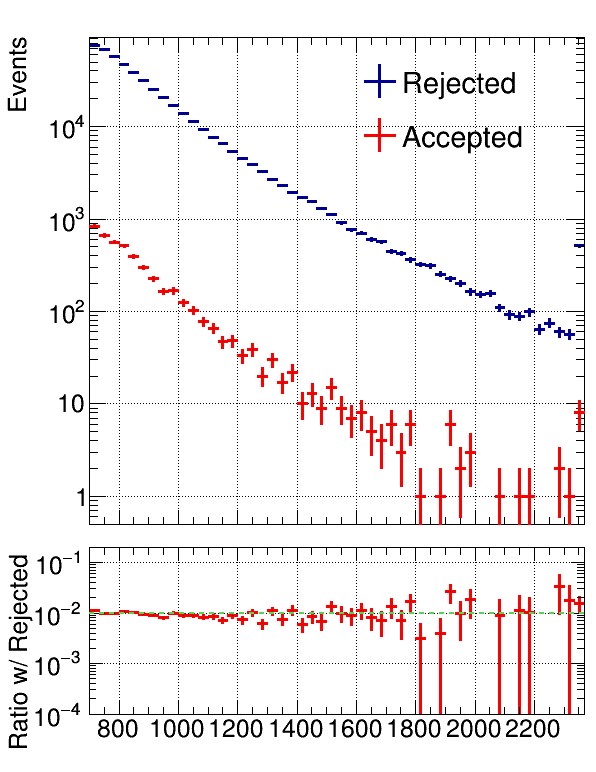

In [12]:
binning=[50, Mjj_selection, np.quantile(data['qcd']['mJJ'], 0.999)]

h_a = create_TH1D(data['qcd']['mJJ'][data['qcd']['sel']], 
                  name='h_acc', title='Accepted',
                  binning=binning,
                  opt='overflow'
                 )
h_a.SetLineColor(2)
h_a.SetStats(0)
h_a.Sumw2()
h_r = create_TH1D(data['qcd']['mJJ'][np.logical_not(data['qcd']['sel'])], 
                  name='h_rej', title='Rejected',
                  axis_title=['M_{jj} [GeV]', 'Events'],
                  binning=binning,
                  opt='overflow'
                 )
h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
h_r.SetStats(0)
h_r.Sumw2()

c_an = make_ratio_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E')
c_an.pad1.SetLogy()
c_an.pad2.SetLogy()

c_an.pad2.cd()
ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
ln.SetLineWidth(2)
ln.SetLineStyle(7)
ln.SetLineColor(8)
ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

c_an.Draw()

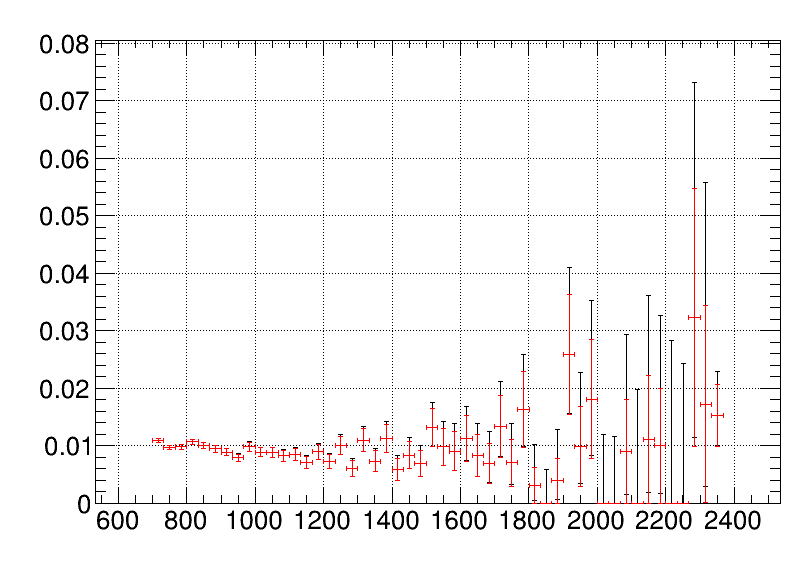

In [13]:
h_aux = h_a.Clone('h_aux')
h_aux.Add(h_a, h_r)

teff = rt.TEfficiency(h_a, h_aux)
teff.SetStatisticOption(rt.TEfficiency.kFCP)

teff2 = rt.TEfficiency(h_a, h_aux)
teff2.SetStatisticOption(rt.TEfficiency.kFNormal)
teff2.SetLineColor(2)

c = create_Canvas()
teff.Draw()
teff2.Draw('SAME')
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


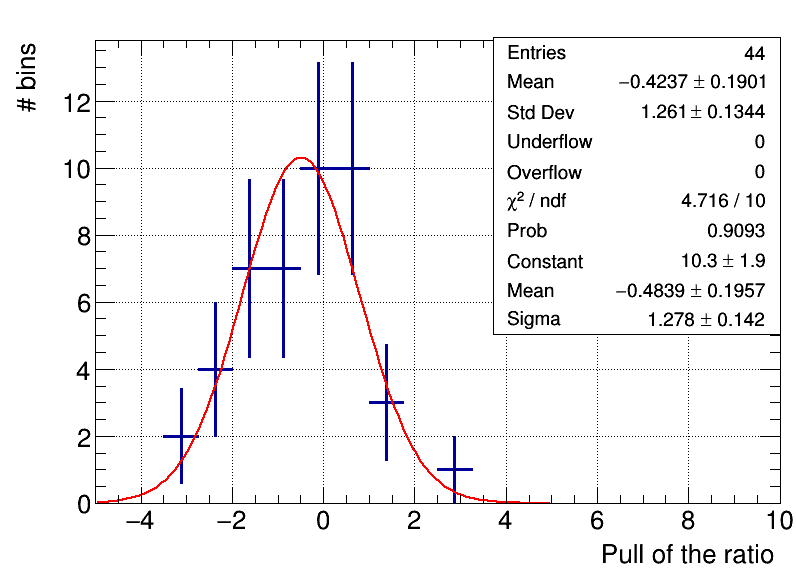

In [14]:
pull = []
for i in range(1,c_an.h_ratio_list[0].GetNbinsX()+1):
    r = c_an.h_ratio_list[0].GetBinContent(i)
    dr = c_an.h_ratio_list[0].GetBinError(i)
    if r == 0:
        continue
    pull.append((r-SM_eff)/dr)
    
h_pull = create_TH1D(np.array(pull), 
                     name='h_pull', title='',
                     binning=[20, -5, 10],
                     axis_title=['Pull of the ratio', '# bins']
                    )
# h_pull.SetStats(0)
h_pull.Sumw2()
h_pull.Fit('gaus', 'QLI', '', -5, 5)
c = create_Canvas()
h_pull.Draw()
c.Draw()

In [15]:
# h_pull = create_TH1D(np.random.rand(30), binning=h_pull.binning)
h_normal_gauss = create_TH1D(np.random.rand(10000), binning=h_pull.binning)
h_normal_gauss.Scale(h_pull.GetEntries()/h_normal_gauss.GetEntries())
h_pull.Chi2Test(h_normal_gauss, 'UWP');

Chi2 = 819.230520, Prob = 1.31332e-172, NDF = 7, igood = 2


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



### See the distribution of SM + BSM

In [16]:
r_SoB_pre = 10e-3


GtoWW
S/B after VAE: 2.32e-01
Improve factor: 23.19


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


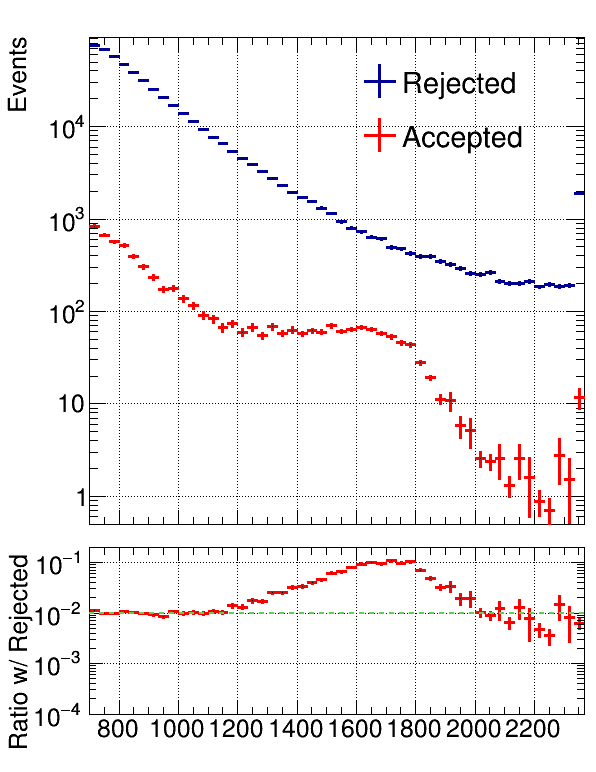

In [17]:
for name_BSM in ['GtoWW']:
    print('\n'+name_BSM)
    N_exp_BSM = data['qcd']['sel'].shape[0] * r_SoB_pre
    if data[name_BSM]['sel'].shape[0] < N_exp_BSM:
        print('Not enought BSM stat')
        continue
    
    scale_f = float(N_exp_BSM)/data[name_BSM]['sel'].shape[0]
    r_SoB_after = scale_f * np.sum(data[name_BSM]['sel']) / np.sum(data['qcd']['sel'])
    print('S/B after VAE: {:1.2e}'.format(r_SoB_after))
    print('Improve factor: {:.2f}'.format(r_SoB_after/r_SoB_pre))
    
    h_a_BSM = create_TH1D(data[name_BSM]['mJJ'][data[name_BSM]['sel']], 
                  name='h_a'+name_BSM,
                  binning=h_a.binning,
                  opt='overflow'
                 )
    h_a_BSM.Sumw2()
    
    h_r_BSM = create_TH1D(data[name_BSM]['mJJ'][np.logical_not(data[name_BSM]['sel'])], 
                  name='h_r'+name_BSM,
                  binning=h_r.binning,
                  opt='overflow'
                 )
    h_r_BSM.Sumw2()
    
    aux_h_a = h_a.Clone('aux_h_a'+name_BSM)
    aux_h_a.Add(h_a, h_a_BSM, 1, scale_f)
    
    aux_h_r = h_r.Clone('aux_h_r'+name_BSM)
    aux_h_r.Add(h_r, h_r_BSM, 1, scale_f)
    aux_h_r.GetYaxis().SetRangeUser(0.5, 1.2*aux_h_r.GetMaximum())
    
    c_an = make_ratio_plot([aux_h_r, aux_h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E')
    c_an.pad1.SetLogy()
    c_an.pad2.SetLogy()

    c_an.pad2.cd()
    ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    ln.SetLineWidth(2)
    ln.SetLineStyle(7)
    ln.SetLineColor(8)
    ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

    c_an.Draw()